# <center>Лабораторная работа №3</center>
###### <center> Сокрытие данных в пространственной области неподвижных изображений на основе прямого расширения спектра</center>
<p>
<center>
_по курсу: "Стеганография"_
</center>
<center>
_Кривич Максим, КБ-41_
</center>
<center>
_Харьков - 2017г._
</center>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.linalg import hadamard
from matplotlib.cbook import get_sample_data

In [2]:
img_tamplate = 'images/img{}.bmp'
steg_img_tamplate = 'images/stego{}.bmp'
text_file = 'text.txt'
eol = '$$'

In [3]:
def np_2_image(array):
    try:
        return Image.fromarray(array)
    except:
        return None

In [4]:
def image_2_np(image):
    try:
        return np.array(image)
    except:
        return None

In [5]:
def open_image_2_np(filename):
    return image_2_np(Image.open(filename))

In [6]:
def read_text(filename):
    with codecs.open(filename, encoding='ascii', mode='r') as f:
        return f.read().strip()

In [7]:
def str_2_bin(*args):
    return ''.join(bin(ord(x))[2:].zfill(8) for x in ''.join(args))

In [8]:
def bin_2_str(binary, length=8):
    bin_l = [binary[i:i+length] for i in range(0, len(binary), length)]
    return ''.join([chr(int(c, 2)) for c in bin_l])

In [9]:
def chunks(l, n, step=4):
    for i in range(0, len(l) - n + 1, step):
        yield l[i:i + n]

### Задание №1 - Реализация алгоритмов формирования ансамблей ортогональных дискретных сигналов Уолша-Адамара и алгоритмов кодирования информационных бит данных сложными дискретными сигналами

In [10]:
def my_hadamard(k, hmat):
    if 2 ** (k-1) == 1:
        return hmat
    else:
        return np.kron(hmat, my_hadamard(k - 1, hmat))

In [11]:
def transform_message(bin_array):
    bin_array[bin_array != 1] = -1
    return bin_array

In [12]:
def inverse_transform_message(array):
    array[array != 1] = 0
    return array

In [13]:
def get_sum(height, message, matrix, k=4, g=3):
    res = []
    for i in range(height):
        a = sum([g*message[k*i+j]*matrix[j+1] for j in range(k) if k*i+j < len(message)])
        if type(a) is int:
                break
        res.append(a)
    return res

In [14]:
%timeit my_hadamard(8, np.matrix([[1,1],[1,-1]]))

878 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Задача №2 - Реализация алгоритмов сокрытия и извлечения данных в пространственной области изображений путем прямого расширения спектров с использованием ортогональных дискретных сигналов

In [15]:
def encode(image, message, matrixm, k=4, g=1):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    result = np.copy(container)
    secret_message = str_2_bin(message, eol)
    l_sm = len(secret_message)
    if height < l_sm:
        raise ValueError('Message is to long for this image')
    
    secret_message = transform_message(np.array([int(i) for i in secret_message]))
    sums = get_sum(height,secret_message, matrix, k=k, g=g)

    for i in range(height):
        for j in range(width):
            if i < len(sums) and j < len(sums[i]):
                nr = result[i, j, 0] + sums[i][j]
                if nr > 255:
                    r = 255
                if nr < 0:
                     nr = 0
                result[i, j][0] = nr
    return np_2_image(result), sums

In [16]:
def decode(image, matrix, k=4, is_bin=False):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    res = []
    
    for i in range(width):
        for j in range(k):
            a = np.array([p[0] for p in container[i]])[:256].dot(matrix[j+1])
            if a > 0:
                res.append(1)
            elif a <= 0:
                res.append(-1)
    res = np.array(res)

    if not is_bin:
        res = bin_2_str(''.join(str(int(i)) for i in inverse_transform_message(res)))
        return res[:res.rfind(eol)]
    else:
        return ''.join(str(int(i)) for i in inverse_transform_message(res))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


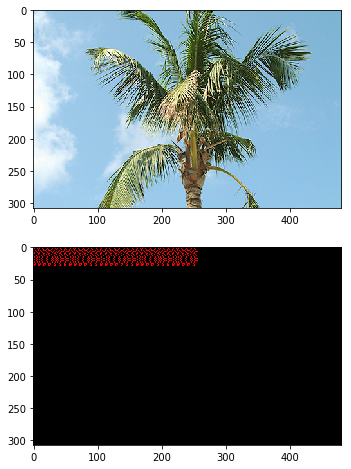

In [17]:
%time
matrix = hadamard(256)
stego_img, sums = encode(img_tamplate.format(2), 'Maxim Krivich', matrix)
stego_img.save(steg_img_tamplate.format(2))


f,ax = plt.subplots(2, figsize=(8, 8))
ax[0].imshow(stego_img)
ax[1].imshow(np_2_image(stego_img - open_image_2_np(img_tamplate.format(2))))
plt.show()

In [18]:
%timeit encode(img_tamplate.format(2), 'Maxim Krivich', matrix)

86.4 ms ± 7.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
for i in range(5):
    print(sums[0].dot(matrix[i]))

0
-256
256
-256
-256


In [20]:
print('PLAINTEXT: ' + decode(steg_img_tamplate.format(2), matrix))
%timeit decode(steg_img_tamplate.format(2), matrix)

ø¦}~&o1³wwýDñùÛ]wÿ3Î&ìÕæ95Õ³%ß¥ÍÀÕõlWµ]s;÷oçýG³Üê)ýÑÆ_µ$êùû_TÊ=Ñû#û ß÷±W#Åz±×»³9Ýr+Ëq»»¿UÝß[ÿý×mUß5
305 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Задача №3 - Проведение экспериментальных исследований вероятностных свойств реализуемого метода, получение эмпирических зависимостей вероятности правильного извлечения данных и доли внесенных при этом погрешностей в контейнер-изображение

In [21]:
%time

Posh_kX = []
Posh_kY = []
W_kX = []
W_kY = []
msg = 'test' * 5

bmsg = str_2_bin(msg)

for i in range(9):
    stego_img, sums =  encode(img_tamplate.format(3), msg, matrix, k=2**i, g=1)
    stego_img.save(steg_img_tamplate.format(3))
    
    res = decode(steg_img_tamplate.format(3), matrix, is_bin=True)
    a = 0
    
    for j in range(len(bmsg)):
        if res[j] != bmsg[j]:
            a += 1
    Posh_kY.append(np.float64(a / len(bmsg)))
    Posh_kX.append(2**i)
    
    w = 0
    
    con1 = open_image_2_np(img_tamplate.format(3))
    con2 = open_image_2_np(steg_img_tamplate.format(3))
    
    for k in range(len(con2)):
        for j in range(len(con2)):
            w = w + abs(con1[k,j,0] - con2[k,j,0])
    W_kX.append((w * 100) / (len(con2) * len(con2[0]) * 256))
    W_kY.append(2**i)

W_kX.reverse()
print(W_kX)
print(W_kY)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in ubyte_scalars


[0.046539306640625, 0.091552734375, 0.13580322265625, 0.25634765625, 0.439453125, 0.8056640625, 1.318359375, 2.1484375, 8.59375]
[1, 2, 4, 8, 16, 32, 64, 128, 256]


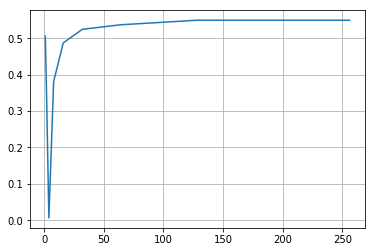

In [22]:
plt.plot(Posh_kX, Posh_kY)
plt.grid(True)
plt.gca().xaxis.grid(True, which='minor')
plt.show()

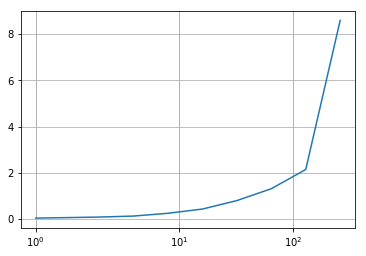

In [23]:
plt.plot(W_kY, W_kX)
plt.xscale('symlog')
plt.grid(True)
plt.gca().xaxis.grid(True, which='minor')
plt.show()

In [24]:
%time

Posh_gX = []
Posh_gY = []
W_gX = []
W_gY = []
msg = 'test' * 5

bmsg = str_2_bin(msg)

for i in range(1, 5):
    stego_img, sums =  encode(img_tamplate.format(3), msg, matrix, k=4, g=i)
    stego_img.save(steg_img_tamplate.format(3))
    
    res = decode(steg_img_tamplate.format(3), matrix, is_bin=True)
    a = 0
    
    for j in range(len(bmsg)):
        if res[j] != bmsg[j]:
            a += 1
    Posh_gY.append(np.float64(a / len(bmsg)))
    Posh_gX.append(i)
    
    w = 0
    
    con1 = open_image_2_np(img_tamplate.format(3))
    con2 = open_image_2_np(steg_img_tamplate.format(3))
    
    for k in range(len(con2)):
        for j in range(len(con2)):
            w = w + abs(con1[k,j,0] - con2[k,j,0])
    W_gX.append((w * 100) / (len(con2) * len(con2[0]) * 256))
    W_gY.append(i)
    
W_gX.reverse()
print(W_gX)
print(W_gY)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in ubyte_scalars


[1.318359375, 1.318359375, 1.318359375, 1.318359375]
[1, 2, 3, 4]


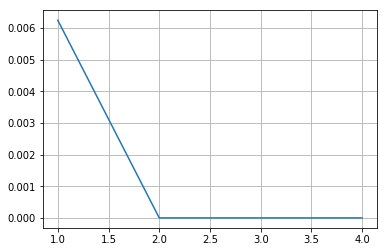

In [25]:
plt.plot(Posh_gX, Posh_gY)
plt.grid(True)
plt.gca().xaxis.grid(True, which='minor')
plt.show()

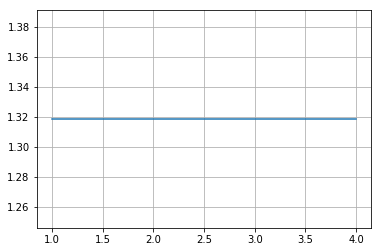

In [26]:
plt.plot(W_gY, W_gX)
plt.grid(True)
plt.show()

### Задание №4 - Реализация алгоритмов формирования ансамблей квазиортогональных дискретных сигналов и алгоритмов сокрытия и извлечения данных в пространственной области изображений использованием квазиортогональных дискретных сигналов

In [27]:
def gen_ansable(size_a=256, size_s=256):
    return np.array(transform_message(np.random.randint(2, size=size_a * size_s))).reshape(size_a, size_s)

In [28]:
def ds_encode(image, message, matrix, g=100):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    result = np.copy(container)
    secret_message = str_2_bin(message, eol)
    l_sm = len(secret_message)
    if height < l_sm:
        raise ValueError('Message is to long for this image')
    print(secret_message)
    M_d = [int(s, 2) for s in chunks(secret_message, 8, 8)]
    sums = []
    for i in range(height):
        if i < len(M_d):
            sums.append(g * matrix[M_d[i]])
#     print(M_d)
    for i in range(height):
        for j in range(width):
            if i < len(sums) and j < len(sums[i]):
                nr = result[i, j, 0] + sums[i][j]
                if nr > 255:
                    r = 255
                if nr < 0:
                     nr = 0
                result[i, j][0] = nr
    return np_2_image(result)

In [29]:
def ds_decode(image, matrix, is_bin=False):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    res = {}
    
    for i in range(width):
        a = 0
        r = np.array([p[0] for p in container[i]])[:256]
        for j in range(len(matrix)):
            cor = r.dot(matrix[j])
            if cor > a:
                a = cor
                res[i] = j
#     print(res)
    msg = []
    for k in sorted(res):
        msg.append(bin(res[k])[2:])
    
    msg = ''.join(i for i in msg)
    print(bin_2_str(msg))
    return msg[:msg.rfind(eol)]

010011010110000101111000011010010110110100100000010010110111001001101001011101100110100101100011011010000010010000100100


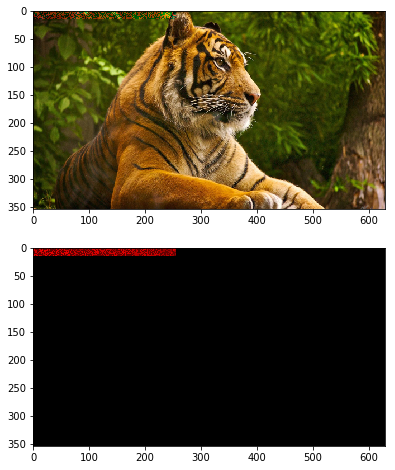

In [30]:
arr = gen_ansable()
res_img = ds_encode(img_tamplate.format(4), 'Maxim Krivich', arr)
res_img.save(steg_img_tamplate.format(4))

f,ax = plt.subplots(2, figsize=(8, 8))
ax[0].imshow(res_img)
ax[1].imshow(np_2_image(res_img - open_image_2_np(img_tamplate.format(4))))
plt.show()

In [31]:
ds_decode(steg_img_tamplate.format(4), arr)

Æ°Kå§¶z$<óÏ<óÏ<ó¤¤¤Ï<ÜÜÜÜóÏ<óÏ<óÏ9©©©¬óÎÛÛ<óÏ=ô÷ïß¿~ýû÷ç{÷ç;ÔÔìÔÔÖù­óTé7ïß¿~ýûæ¦¦·æjjjjk3Yß5555555yçyçyçyçyçyçyçyçyçyçyçIyçnnnnnpùçyçyçyçyçy¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹¹³SSSSSS[÷ïß¾vvvvvVvw~ýû÷ïß¿|Öýû÷ïß55555¾jjjjjjk|ÔÔÔÔÔÔÔÔÔÔÔÔÔÔÔÔÔÔÔÖù©©¬óÏ<óÏ<æ³ÍÍ


'100110111000011111000110100111011011000001001011111001011010011110110110100111000111101000100100100100110011110011110011110011110011110011110011110011110011110011110011101001001010010010100100110011110011110011011100110111001101110011011100111100111100111100111100111100111100111100111100111100111100111100111001101010011010100110101001101011001111001111001110100100101001001010010010100100111101101111011011001111001111001111001111001111011111010010011011111101111110111111011111101111110111111011111101111110111111011111100111100111100111101111110111111001110011101110011100110101001101010011101100110101001101010011010110111110011010110111110011010101001001010010010100100101001001010010010100100101001001010010010100100101001001101111101001001101111110111111011111101111110111111011111101111110111110011010100110101001101011011111100110011010100110101001101010011010100110101100110011010110011001101010011010100110101001101010011010100110101001101010011010100001111000011111011111001101010011010